# Anomaly Detection Performance Evaluation

Ok so let's say you have a time series, and an anomaly detection algoritm that you can use to detect anomalies. If you have a labeled dataset, the performance of your anomaly detection algorithm can be easily measured using metrics like precision, recall, or F1-score. But what if it’s not labeled?

## Synthetic Anomalies Detection
A way to assess the performance of your method is to manually inject **synthetic anomalies** in your time series., as shown in the image below:

![Anomaly Example](notebook_images/anomaly_injection.png)

In this case, the anomaly is a localized **spike** in the input time series. 

A successfull outcome of the anomaly detection algorithm is seen in the following image: the anomaly detection perfectly spots the point where the anomaly has been previously injected.

![Anomaly Example](notebook_images/anomaly_detection_output.png)

Of course, an unsuccesfull outcome would be when the anomaly detector does not spot the previously injected anomaly. 

## Synthetic Anomalies Parameters

These synthetic anomalies can be used to build a labeled dataset, as we now have full control over where the "true" anomalies occur. Nonetheless, multiple parameters can influence our anomaly detection:

1. The **kind** of injected anomalies: what do our injected anomalies look like?
2. The specific **anomaly detection algorithm** we are adopting.
3. The **size** of our anomalies: how "big" do we assume our anomalies to be?
4. The **location** of our anomalies in the time series.

### Fixed parameters

The first two parameters (**kind** and **anomaly detection algorithm**) are fixed in this blogpost.

A reasonable assumption for the **"kind"** of anomaly is a localized **spike**. In our weather dataset, where the amplitude (y-axis) represents temperature in Kelvin and the x-axis represents time in hours, the **spike** corresponds to a temperature that is significantly higher than average.

The **anomaly detection algorithm** that we will be testing is the ```TimeGPT-1``` model, developed by the [Nixtla](https://www.nixtla.io/) team. The idea is to use the **transformer** algorithm and conformal probabilities to get accurate predictions and uncertainty boundaries. You can read more about it in the original [paper](https://arxiv.org/abs/2310.03589), while another application of anomaly detection throught TimeGPT-1 can be found in this [blogpost](https://www.nixtla.io/blog/anomaly-detection-in-time-series-with-timegpt-and-python).


### Non Fixed Parameters/Variables
By varying the last two parameters (**size** and **location**), we calibrate the evaluation scenario to explore the model's robustness. This allows us to assess its performance across a range of realistic anomaly cases. For example, an image showing injected anomalies at varying sizes and locations can be seen in the image below:


![table_first](notebook_images/table_first.png)


Why is this important? If you think about it, when the anomaly size is huge, a whatever anomaly detection model (even a very simple one) would be able to easily spot it. Nonetheless, when the anomaly size is almost zero, even a very powerful anomaly detection model would struggle to detect it, as shown in the image showing anomalous signals with different injected anomalies (shown in red).


![table_first](notebook_images/table_second.png)


As we can see, it is visually easy to spot anomalies at size = 0.1, but it is much harder to spot them at size = 0.05. 

## Anomaly Detection Performance Evaluation

The question we want to ask ourself is the following:
***"What is the smallest anomaly that we can detect through our algorithm?"***

In order to understand how the location and size influences the performance of TimeGPT's anomaly detection, we can run the following approach:
1. We fix the **size** of the anomaly (e.g. size = 0.1 $\times$ the average of the signal). 
2. We apply the anomaly across multiple locations of the signal, as shown in the image below
![Anomaly Example](notebook_images/anomaly_fixed_threshold.png)


3. For every anomalous signal (across multiple locations), we run the anomaly detection algorithm and see if the anomaly in the injected location has been detected or not.
4. We measure the performance across multiple locations, for example using: 
$$\text{Accuracy} = \frac{\text{Number of detected anomalies}}{\text{Number of anomalies}}$$
5. If the accuracy is satisfactory, we decrease the the **size** of the anomaly, and repeat the loop from step 2, otherwise, we have found our smallest detectable anomaly size. 

In [1]:
from data import *
data = Data(datetime_column='datetime')
data.isolate_city()
data.isolate_portion()
preprocessed_data = data.prepare_for_nixtla()
preprocessed_data.head()

,y,ds,unique_id
0,297.96,2017-06-16 09:00:00,0
1,297.15,2017-06-16 10:00:00,0
2,295.80,2017-06-16 11:00:00,0
3,295.00,2017-06-16 12:00:00,0
4,294.33,2017-06-16 13:00:00,0


Text(0, 0.5, 'Amplitude')

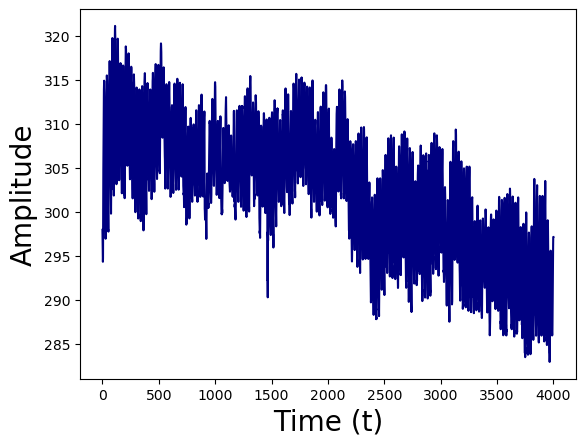

In [23]:
from plotter import *
import matplotlib.pyplot as plt
import numpy as np
signal = np.array(preprocessed_data['y'])
position = 100
threshold = 0.05
window = 250
anomalous_signal = add_anomaly(signal = signal, position = position, threshold = threshold, window = window)
plt.plot(np.abs(anomalous_signal), color = 'navy')
plt.xlabel('Time (t)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)


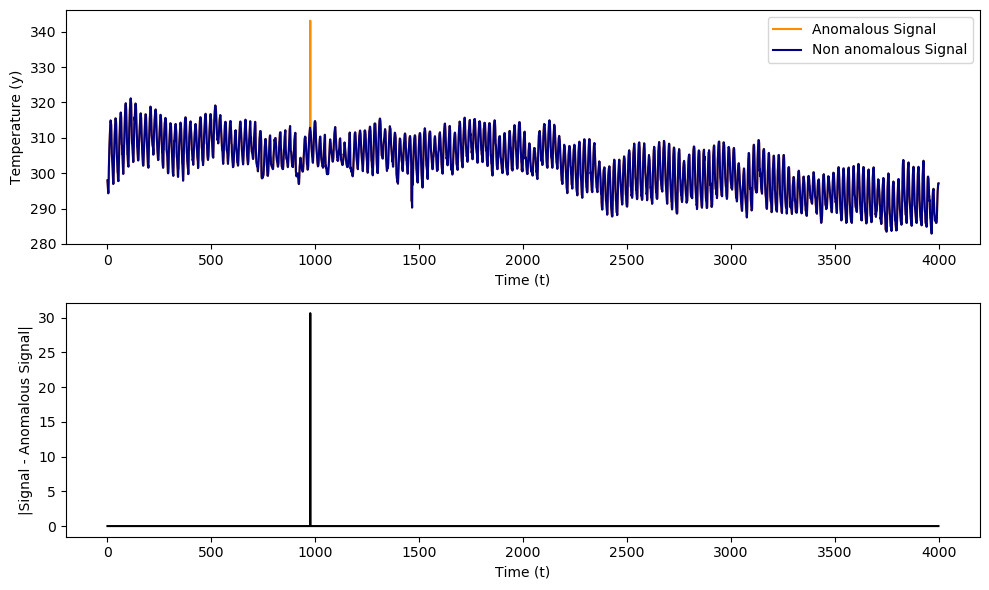

In [2]:
from plotter import *
signal = np.array(preprocessed_data['y'])
position = None
threshold = 0.1
window = 50
anomalous_signal = add_anomaly(signal = signal, position = position, threshold = threshold, window = window)
plot_normal_and_anomalous_signal(signal, anomalous_signal)

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from nixtla import NixtlaClient
import os

load_dotenv()  # looks for .env in current directory
api_key = os.environ["NIXTLA_API_KEY"]
nixtla_client = NixtlaClient(api_key=api_key)

In [3]:
anomalies_df = nixtla_client.detect_anomalies(
    preprocessed_data,
    freq="H",
    model="timegpt-1",
)
anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,0,2017-06-22 01:00:00,319.60,319.71375,324.28970,315.13780,False
1,0,2017-06-22 02:00:00,319.52,319.36737,323.94333,314.79140,False
2,0,2017-06-22 03:00:00,317.77,318.26680,322.84277,313.69086,False
3,0,2017-06-22 04:00:00,315.15,315.85300,320.42896,311.27704,False
4,0,2017-06-22 05:00:00,312.70,312.91196,317.48790,308.33600,False


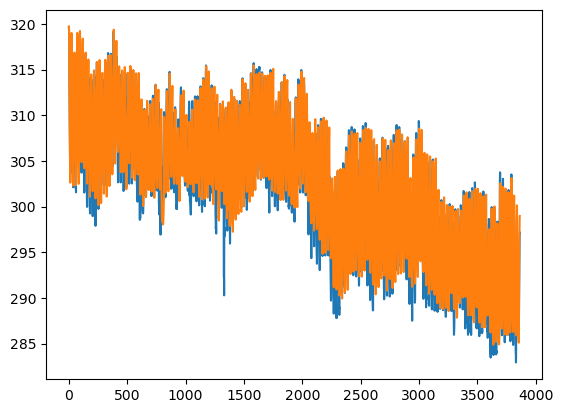

In [4]:
import matplotlib.pyplot as plt
plt.plot(anomalies_df['y'])
plt.plot(anomalies_df['TimeGPT'])

In [34]:
np.arange(-1,1.001,0.001)

[-1.    -0.999 -0.998 ...  0.998  0.999  1.   ]
